In [ ]:
#!pip install flopy

In [2]:
import os, sys
# Temporal, para agregar las rutas correctas
%run ../../../src/xmf6/ruta_temporal.py
if not(src_path in sys.path[0]):
    sys.path.insert(0, os.path.abspath(a_path + src_path)) 

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import flopy
import xmf6
import WMA_1D as WMA
from flow_1D import build_gwf_1D

### Parámetros físicos.

* Al utilizar un valor de porosidad uniforme de 0.5, se obtiene un valor de velocidad de 0.4 $m/d$ como resultado de la inyección de agua a una razon de 0.2 $m^3/d$ en la primera celda.
* A la última celda se le asigna una carga constante con un valor de 1 $m$
* A la concentración del agua inyectada se le asigna un valor de 1.0, y cualquier agua que salga a través de la celda de carga constante sale con la concentración simulada del agua en esa última celda.
* La advección se resuelve utilizando el esquema TVD para reducir la dispersión numérica.
  
|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---|
|Specific discharge |0.2| m/d  | `ph_par['specific_discharge']` |
|Hydraulic conductivity |1.0| m/d | `ph_par['hydraulic_conductivity']` |
|Source concentration |1.0| unitless | `ph_par['source_concentration']` |
|Porosity | 0.5 | unitless |  `ph_par['porosity']` |
|Initial Concentration | 0.0 | unitless | `ph_par['initial_concentration']` |
|Longitudinal Dispersivity | 0.1 |  | `ph_par['longitudinal_dispersivity']` |
|Retardation Factor | 1.0 |  | `ph_par['retardation_factor']` |
|Decay Rate | 0.0 |  | `ph_par['decay_rate']` |
|Dispersion coefficient | | | `ph_par["dispersion_coefficient"]` |

$$
\text{Dispersion Coefficient} = \dfrac{\text{Longitudinal Dispersivity} \times \text{Specific Discharge}}{\text{Retardation Factor}}
$$

In [5]:
os_par = dict(
    ws = os.getcwd() + '/output', # Ruta de donde estamos actualmente
    mf6_exe = 'C:/Users/leo_teja/Documents/GitHub/RTWMA/mf6/bin/binWin/mf6', # Ejecutable
    flow_name = 'flow', # Nombre de la simulación para flujo
    tran_name = 'transport' # Nombre de la simulación para transporte
)
xmf6.nice_print(os_par, 'MODFLOW 6 environment')
                     
oc_par = dict(
    head_file = f"{os_par['flow_name']}.hds",
    fbudget_file = f"{os_par['flow_name']}.bud",
    concentration_file=f"{os_par['tran_name']}.ucn",
    tbudget_file = f"{os_par['tran_name']}.bud",
)
xmf6.nice_print(oc_par, 'Output files')

mesh = xmf6.MeshDis(
    nrow = 1,    # Number of rows
    ncol = 30,  # Number of columns
    nlay = 1,    # Number of layers
    row_length = 30.0,    # Length of system ($m$)
    column_length = 1.0,  # Length of system ($m$)
    top = 1.0,   # Top of the model ($m$)
    bottom = 0,  # Layer bottom elevation ($m$)
)
xmf6.nice_print(mesh, 'Space discretization')

tdis = xmf6.TDis(
    perioddata = ((40, 40, 1.0),) # PERLEN, NSTP, TSMULT
)
xmf6.nice_print(tdis, 'Time discretization')

ml_units = {
    "time": "days",
    "length": "meters"
}
xmf6.nice_print(ml_units, 'Units')

ph_par = dict(
    specific_discharge = 0.2,  # Specific discharge ($m day^{-1}$)
    hydraulic_conductivity = 1.0,  # Hydraulic conductivity ($m day^{-1}$)
    source_concentration = 1.0,  # Source concentration (unitless)
    porosity = 0.5,  # Porosity of mobile domain (unitless)
    initial_concentration = 1.0,  # Initial concentration (unitless)
    longitudinal_dispersivity  = 0.0,
    retardation_factor  = 1.0,
    decay_rate  = 0.0,
    dispersion_coefficient = 0.2
)
xmf6.nice_print(ph_par, 'Physical parameters')


MODFLOW 6 environment
------------------------------
                  ws = C:\Users\leo_teja\Documents\GitHub\RTWMA\benchmarks\GWF-DFC-WMA\YESO_1D/output
             mf6_exe = C:/Users/leo_teja/Documents/GitHub/RTWMA/mf6/bin/binWin/mf6
           flow_name = flow      
           tran_name = transport 

Output files
------------------------------
           head_file = flow.hds  
        fbudget_file = flow.bud  
  concentration_file = transport.ucn
        tbudget_file = transport.bud

Space discretization
------------------------------
NX =           30 (ncol)
NY =            1 (nrow)
NZ =            1 (nlay)
LX =       30.000 (row)
LY =        1.000 (col)
LZ =        1.000 (lay)
DX =  1.00000e+00 (delr)
DY =  1.00000e+00 (delc)
TOP=        1.000 (top)
BOT=        0.000 (bottom)
DZ =  1.00000e+00 (top-botm)

Time discretization
------------------------------
      NPER = 1       
TOTAL TIME = 40.00

PER     PERLEN     NSTP     TSMULT        Dt1
  1      40.00      40.00       1.00

# Ruta GWF-DFC-WMA (Modflow-Diferencias Finitas - WMA)
## 1. Relsolviendo el problema de flujo mediante GWFw

In [6]:
# Construcción del Modelo GWF
sim_f, gwf = build_gwf_1D(mesh, tdis, ph_par, ml_units, os_par, oc_par)
sim_f.write_simulation(silent=True)

In [7]:
sim_f.run_simulation(silent=True)

(True, [])

## Obtención de los datos de las cargas ($h$) y descargas hidraúlicas ($q$): 

In [8]:
of = xmf6.OFiles(os_par, oc_par)
qx, _, _ = of.get_q(gwf)
head = of.get_head()
xi = mesh.get_coords('X')
print(qx)
print(head)

[[[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
   0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]]]
[[[6.8 6.6 6.4 6.2 6.  5.8 5.6 5.4 5.2 5.  4.8 4.6 4.4 4.2 4.  3.8 3.6
   3.4 3.2 3.  2.8 2.6 2.4 2.2 2.  1.8 1.6 1.4 1.2 1. ]]]


# Solución del problema de transporte
## 1. Calculo de las proporciones de mezcla $\lambda$ 

In [9]:
nx_div=1   #numero de divisiones para dx
directory = "C:/Users/leo_teja/Documents/GitHub/RTWMA/TR_1D_oper/input/gypsum_eq" #Directorio donde se guardaran las proporciones de mezcla 

lambdas1D = WMA.mixingRatios1D(directory,ph_par, mesh, tdis, head, qx, nx_div, verb=0)
print(lambdas1D)


Data written to C:/Users/leo_teja/Documents/GitHub/RTWMA/TR_1D_oper/input/gypsum_eq\WMA_lambdas_gypsum_eq.dat successfully.
[[3.20000000e+01 0.00000000e+00 3.46688069e-01 5.77813448e-01
  6.67736760e-02 7.71654559e-03 8.91744762e-04 1.03052423e-04
  1.19090152e-05 1.37623782e-06 1.59041744e-07 1.83792917e-08
  2.12396038e-09 2.45450574e-10 2.83649285e-11 3.27792742e-12
  3.78806109e-13 4.37758528e-14 5.05885528e-15 5.84614922e-16
  6.75596727e-17 7.80737748e-18 9.02241540e-19 1.04265459e-19
  1.20491969e-20 1.39243760e-21 1.60913834e-22 1.85956355e-23
  2.14896211e-24 2.48341150e-25 2.87027460e-26 3.32785460e-27
  4.15981826e-28]
 [3.20000000e+01 0.00000000e+00 1.20192617e-01 2.00321028e-01
  6.00963084e-01 6.94489103e-02 8.02570286e-03 9.27471808e-04
  1.07181137e-04 1.23861404e-05 1.43137570e-06 1.65413625e-07
  1.91156434e-08 2.20905517e-09 2.55284356e-10 2.95013468e-11
  3.40925498e-12 3.93982675e-13 4.55296975e-14 5.26153430e-15
  6.08037055e-16 7.02663974e-17 8.12017386e-18 9.383

## 2. Ejecutando el WMA Carrera-Jordi (TR_1D_oper.exe)

In [10]:
import subprocess

# Path to the .exe file
exe_path = r"C:\Users\leo_teja\Documents\GitHub\RTWMA\TR_1D_oper\TR_1D_oper.exe"
working_dir = r"C:\Users\leo_teja\Documents\GitHub\RTWMA\TR_1D_oper"

# Running the .exe file
print("########################################")
print("CORRIENDO EJECUTABLE TR_1D_oper.exe")
print("#################################### ","\n")
result = subprocess.run([exe_path], cwd=working_dir, capture_output=True, text=True)
#
#Output from the program
print("Standard Output:", result.stdout)
print("Standard Error:", result.stderr)
print("########################################")
print("FIN DEL EJECUTABLE")
print("########################################")

########################################
CORRIENDO EJECUTABLE TR_1D_oper.exe
####################################  

Standard Output:  ca+2                                                                           
                                                                                
                                                                                
                    
 so4-2                                                                          
                                                                                
                                                                                
                    
 gypsum                                                                         
                                                                                
                                                                                
                    
 ca+2                                                                     

## 3. Importando resultados del archivo gypsum_eq.out

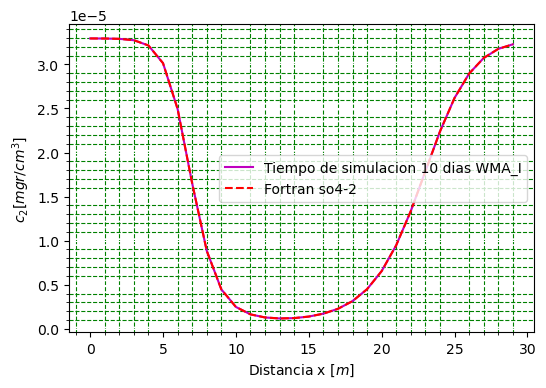

In [11]:
import matplotlib.pyplot as plt
import resultsFortran as rF  #importa los resultados del WMA

#--------------------------------------------------------------------------------------------------#
#------------------------ Graficando un solo resultado y comparandolo vs WMAI ----------------------#
#---------------------------------------------------------------------------------......---------#
import pandas as pd

tsel=10   #tiempo seleccionado de hoja excel

file_name='gypsum_eq.out'   #el archivo solo cuenta con los resultados finales
file_path = os.path.join(working_dir, file_name)

Res_contrsns_ini = []
Res_contrsns_fin = []
Res_contrsns_ini, Res_contrsns_fin = rF.import_results(file_path)

plt.figure('C2',figsize=(6,4))
WMA_I=pd.read_excel('comparativa_02.xlsx', sheet_name='c_2')     #Crea un data frame llamado WMA_I a partir de la tabla de excel
data_set_C2 = np.transpose(WMA_I.iloc[11:,5:95].to_numpy())
plt.plot(np.arange(30), data_set_C2[tsel][:], "-m", label="Tiempo de simulacion "+str(round(tsel,2))+" dias WMA_I" )
plt.plot(np.arange(30), Res_contrsns_fin[1][:], "r--", label="Fortran so4-2 ")
plt.xlabel("Distancia x [$m$]"), plt.ylabel("$c_2 [mgr/cm^{3}]$")
plt.legend(loc=0); plt.minorticks_on()
plt.grid(True,which='major', color='w', linestyle='-')
plt.grid(True, which='minor', color='g', linestyle='--')
plt.show()

#print(Res_contrsns_fin)